# eclipse depth constraint

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Distance
from isochrones import get_ichrone
tracks = get_ichrone('mist', tracks=True)

In [22]:
#toi179
import numpy as np

TEFF = 5058
FEH = -0.137198
LOGG = 4.564691
RSTAR = 0.838949
MSTAR = 0.815533
DISTANCE = 38.5

LOG10AGE = np.log10(600e6)
DEPTH_OBS = 0.0011345367429999999
DEPTH_OBS_ERR = 0.0005
AV= 0

In [49]:
tracks.generate?

In [23]:
tracks.generate(MSTAR, LOG10AGE, FEH, distance=DISTANCE, AV=0, return_dict=True) 

{'logL': -0.45887943514039903,
 'density': 2.919205002095364,
 'mass': 0.8155241900303363,
 'radius': 0.7334459245561785,
 'eep': 273.70587972271994,
 'Mbol': 5.887198587850998,
 'delta_nu': 202.6397854254687,
 'nu_max': 4969.130906771914,
 'phase': 0.0,
 'Teff': 5179.8653579242955,
 'initial_mass': 0.8155329999999997,
 'feh': -0.10500573000998137,
 'logg': 4.618959612010775,
 'logTeff': 3.7140059042553615,
 'interpolated': 0.0,
 'star_age': 618874789.5719788,
 'age': 8.788412562146855,
 'dt_deep': 0.01436751017014461,
 'J_mag': 7.5417910996287985,
 'H_mag': 7.08669165257109,
 'K_mag': 7.029391087092193,
 'G_mag': 8.798662156151005,
 'BP_mag': 9.215778814032292,
 'RP_mag': 8.219599013897023,
 'W1_mag': 7.00871855949824,
 'W2_mag': 7.049257819163855,
 'W3_mag': 6.990343519998625,
 'TESS_mag': 8.210862235479933,
 'Kepler_mag': 8.700950121204952,
 'distance': 38.5,
 'AV': 0.0,
 'initial_feh': -0.137198,
 'requested_age': 8.778151250383644}

In [24]:
def masses_to_HEB_eclipse_depth(mass1, mass2, mass3, log10age, feh, F0=1, bandpass='TESS_mag'):
    """
    passband dependent, based on magnitude
    
    assumes MIST, b=0
    
    """
    star1 = tracks.generate(mass1, log10age, feh, return_dict=True) 
    mag1 = star1[bandpass]

    star2 = tracks.generate(mass2, log10age, feh, return_dict=True) 
    mag2 = star2[bandpass]

    star3 = tracks.generate(mass3, log10age, feh, return_dict=True) 
    mag3 = star3[bandpass]

    rstar1 = star1['radius']
    rstar2 = star2['radius']
    rstar3 = star3['radius']
    
    #mag = -2.5*log10(F/F0)
    f1 = F0*10**(-0.4*mag1)
    f2 = F0*10**(-0.4*mag2)
    f3 = F0*10**(-0.4*mag3)
    
    # total flux during out of eclipse
    f_ooe = f1 + f2 + f3

    # in eclipse. assume maximum depth
    f_ie = f2*(rstar3/rstar2)**2
    
    return f_ie/f_ooe

In [25]:
def likelihood(model, data, err):
    return (1/np.sqrt(2*np.pi*err**2))*np.exp(-((data-model)/err)**2)

In [26]:
depth_true = masses_to_HEB_eclipse_depth(MSTAR, 0.1, 0.1, LOG10AGE, FEH)
likelihood(depth_true, DEPTH_OBS, DEPTH_OBS_ERR)

104.27277838734896

## mass grid

In [54]:
import matplotlib.colors as mcolors

class MidPointLogNorm(mcolors.LogNorm):
    """
    Log normalization with midpoint offset
    
    from
    https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))
    
def plot_eclipse_depth_grid(mass_grid, cmap='default'):
    """
    """
    fig, ax = pl.subplots(1,1, figsize=(8,8))
    xmin, xmax = m2s[0], m2s[-1]
    ymin, ymax = m3s[0], m3s[-1]

    norm = MidPointLogNorm(vmin=mass_grid.min(), 
                                 vmax = mass_grid.max(), 
                                 midpoint=0
                                )
    #plot matrix
    cbar = ax.imshow(mass_grid, 
                     origin='lower', 
                     interpolation='none', 
                     extent=[xmin, xmax, ymin, ymax], 
                     cmap=cmap,
                     #norm=norm
                    )
    pl.colorbar(cbar, ax=ax, #shrink=0.9,
                label='Likelihood', orientation="vertical")

    # add labels
    # ax.set_aspect(5)
    pl.setp(ax,
            xlim=(xmin,xmax),
            ylim=(ymin,ymax),
            xlabel='secondary star mass (Msun)',
            ylabel='tertiary star mass (Msun)'
           );
    return fig

## multi-band

In [59]:
passbands = 'TESS_mag J_mag H_mag K_mag'.split()

N_samples = 20

m2s = np.linspace(0.05, 0.5, N_samples)
m3s = np.linspace(0.05, 0.5, N_samples)


mass_grids = {} 
for bp in passbands:
    mass_grid = np.zeros((N_samples,N_samples))
    for i,m2 in enumerate(m2s): 
        for j,m3 in enumerate(m3s):
            depth = masses_to_HEB_eclipse_depth(1.0, m2, m3, LOG10AGE, FEH, bandpass=bp)
            ll = likelihood(depth, 0.01, 0.005)
            mass_grid[i,j] = ll
    mass_grids[bp] = mass_grid

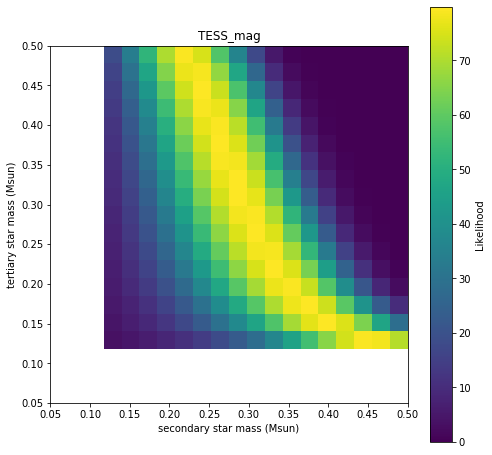

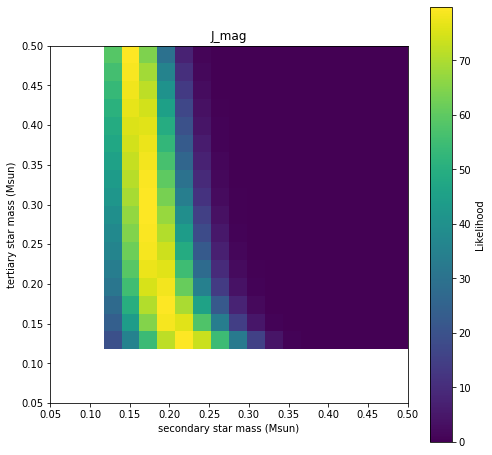

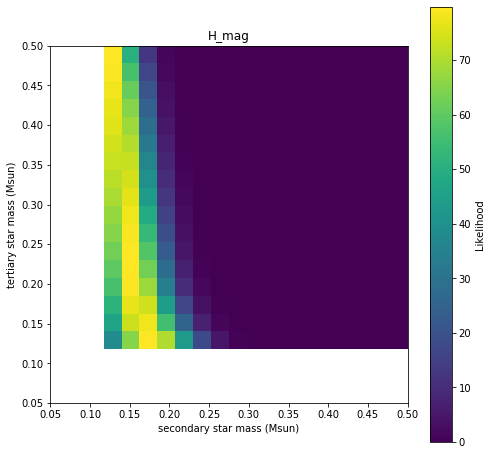

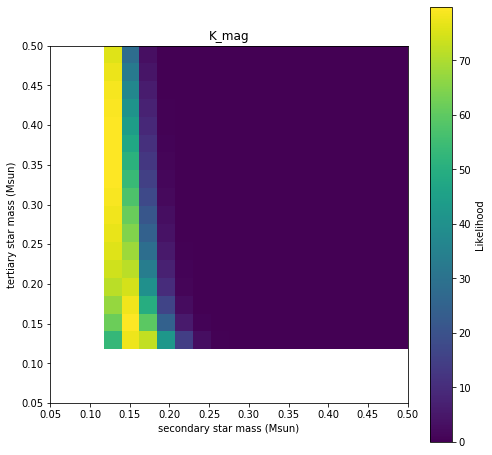

In [60]:
for bp in passbands:
    fig = plot_eclipse_depth_grid(mass_grids[bp], cmap='viridis')
    fig.axes[0].set_title(bp)

# eclipse shape constraint

In [42]:
def tshape_approx(k, b=0):
    """transit shape approximation
    See Seager & Mallen-Ornelas 2003, eq. 15
    """
    alpha = (1 - k) ** 2 - b ** 2
    beta = (1 + k) ** 2 - b ** 2
    return np.sqrt(alpha / beta)


def max_k(tshape):
    """maximum depth due to contaminant
    Seager & Mallen-Ornelas 2003, eq. 21


    Check: max_k(ts)*u.Rsun.to(u.Rearth)=1
    """
    return (1 - tshape) / (1 + tshape)

In [62]:
import chronos as cr

p = cr.Planet(toiid=179)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Target: TOI 179
Searching Vizier: (44.262 -56.1919) with radius=3.0 arcsec


In [63]:
p.toi_period

4.1373940000000005

In [43]:
RpRs = 0.03
TSHAPE = tshape_approx(RpRs, b=0)
TSHAPE_ERR = tshape_approx(0.076, b=0.3)
TSHAPE, TSHAPE_ERR

(0.941747572815534, 0.8457517910499825)

In [44]:
MAX_K = max_k(TSHAPE)
MAX_K_ERR = max_k(TSHAPE_ERR)
MAX_K, MAX_K_ERR

(0.029999999999999985, 0.08356931289351269)

/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


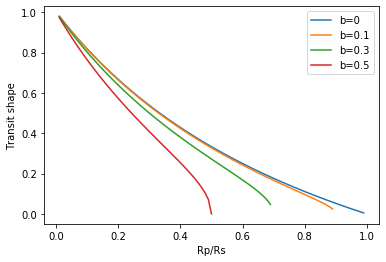

In [45]:
ks = np.arange(0.01, 1, 0.01)

pl.plot(ks, tshape_approx(ks, b=0), label="b=0")
pl.plot(ks, tshape_approx(ks, b=0.1), label="b=0.1")
pl.plot(ks, tshape_approx(ks, b=0.3), label="b=0.3")
pl.plot(ks, tshape_approx(ks, b=0.5), label="b=0.5")
pl.xlabel('Rp/Rs')
pl.ylabel('Transit shape')
pl.legend()

/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


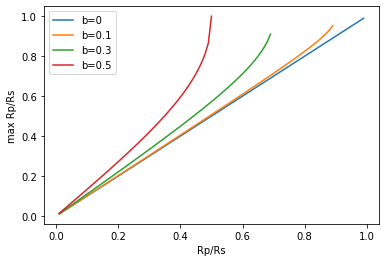

In [46]:
ks = np.arange(0.01, 1, 0.01)

pl.plot(ks, max_k(tshape_approx(ks, b=0)), label="b=0")
pl.plot(ks, max_k(tshape_approx(ks, b=0.1)), label="b=0.1")
pl.plot(ks, max_k(tshape_approx(ks, b=0.3)), label="b=0.3")
pl.plot(ks, max_k(tshape_approx(ks, b=0.5)), label="b=0.5")
pl.xlabel('Rp/Rs')
pl.ylabel('max Rp/Rs')
pl.legend()

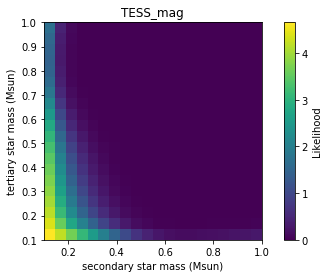

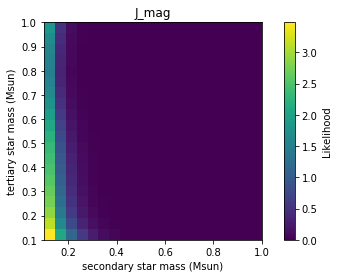

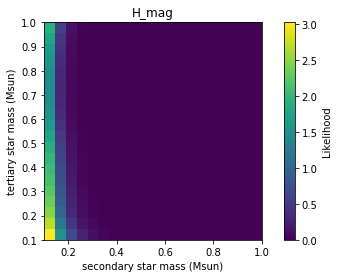

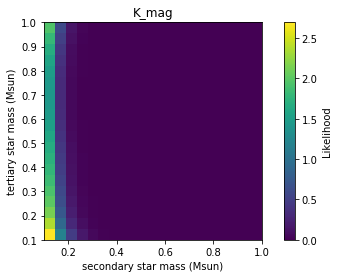

In [48]:
passbands = 'TESS_mag J_mag H_mag K_mag'.split()

mass_grids = {} 
for bp in passbands:
    mass_grid = np.zeros((N_samples,N_samples))
    for i,m2 in enumerate(m2s): 
        for j,m3 in enumerate(m3s):
            depth = masses_to_HEB_eclipse_depth(MSTAR, m2, m3, LOG10AGE, FEH, bandpass=bp)
            k = np.sqrt(depth)
            tshape = tshape_approx(k, b=0)
            kmax = max_k(tshape)
            ll = likelihood(kmax, MAX_K, MAX_K_ERR)
            mass_grid[i,j] = ll
    mass_grids[bp] = mass_grid
    
for bp in passbands:
    fig = plot_eclipse_depth_grid(mass_grids[bp], cmap='viridis')
    fig.axes[0].set_title(bp)